# Shadows of a Pandemic
<hr>

## Introduction
In 2020, at least 3 million people died of COVID-19 (WHO). How might this astronomical figure have been prevented? If we had known that the pandemic was approaching, maybe governments could have put more measures in place and the spread of this virus would have been less severe. My science fair project, “Shadows of a Pandemic,” aims to do just that, using the novel approach of training an image recognition model on plots of word representations . By predicting pandemics, it will enable us to be more prepared for the next pandemic, and perhaps even avoid it completely. 


How might we do so? Well, we can plot out the Eigenvalues of [Google Search Terms](https://console.cloud.google.com/marketplace/product/bigquery-public-datasets/google-search-trends) using PCA, generate heat maps from them, and run image classification on them! Let's get straight into it.
## Setup
### Import Libraries

In [1]:
# Import Required Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import time
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from gensim.models import KeyedVectors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

2024-03-18 22:07:07.209310: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-18 22:07:07.209414: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-18 22:07:07.365139: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Open files
The start of all our processes is data, as it is not possible to train an AI without data. I use data extracted from [Google BigQuery’s “Google Trends Top 25 Terms”](https://console.cloud.google.com/marketplace/product/bigquery-public-datasets/google-search-trends) which contains 4 databases, one with international top terms, one with international top rising terms, one with the top terms in the United States, and one with the top rising terms in the United States. Of these, our data was extracted from the international top terms database. It was selected from various dates and grouped into several CSV(Comma Separated Values) files; with the rows of weeks that I deemed fall under no pandemic, I inserted the rows into a file called no-pandemic. I also did the same for pre-pandemic, as well as peak-pandemic. We open them as DataFrames here:

In [2]:
# Open files
no_pandemic = pd.read_csv("/kaggle/input/pandemic/pandemic_data/no-pandemic.csv")
pre_pandemic = pd.read_csv("/kaggle/input/pandemic/pandemic_data/pre-pandemic.csv")
peak_pandemic = pd.read_csv("/kaggle/input/pandemic/pandemic_data/peak-pandemic.csv")


## Cleaning
Cleaning is necessitated to make vectorization work properly. Because Word2Vec (the word embedder we use) can only take in english words from A to Z, it is necessary that we clean the data to rid words that have letters otherwise.

But first...
### Drop unnecessary information
We need to change the data into a format that we can work with. Here we change the data so that each week corresponds to a list of terms.

In [3]:
# Change into format Week: [Term1, Term2, Term3, ...]

# no_pandemic
no_pandemic_terms_series = no_pandemic.groupby(['week'])['term'] .apply(list)
no_pandemic_terms = pd.DataFrame({'week':no_pandemic_terms_series.index, 'term':no_pandemic_terms_series.values})

# pre_pandemic
pre_pandemic_terms_series = pre_pandemic.groupby(['week'])['term'] .apply(list)
pre_pandemic_terms = pd.DataFrame({'week':pre_pandemic_terms_series.index, 'term':pre_pandemic_terms_series.values})

# peak_pandemic
peak_pandemic_terms_series = peak_pandemic.groupby(['week'])['term'] .apply(list)
peak_pandemic_terms = pd.DataFrame({'week':peak_pandemic_terms_series.index, 'term':peak_pandemic_terms_series.values})

### Preform NLP
Now, we can filter out terms with non a-z characters so Word2Vec can take it as input.

In [4]:
# Preform NLP; filter out all terms with non a-z characters

# Filters out non a-z characters (except for numbers)
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

# Filters out numbers
def filter_non_alphabetical(lst):
    return [word for word in lst if (isEnglish(word)) and (word.isalpha())]

# Apply filters
no_pandemic_terms["term"] = no_pandemic_terms["term"].apply(filter_non_alphabetical)
pre_pandemic_terms["term"] = pre_pandemic_terms["term"].apply(filter_non_alphabetical)
peak_pandemic_terms["term"] = peak_pandemic_terms["term"].apply(filter_non_alphabetical)

### Split search terms into words
The Word2Vec model we use only takes in one word at a time, so we must split up each search term into several search terms.

In [5]:
# Seperate all search term words into one list

# Filter splits lists
def split_list(lst):
    return ' '.join(lst).split()

# Apply filter
no_pandemic_terms["term"] = no_pandemic_terms["term"].apply(split_list)
pre_pandemic_terms["term"] = pre_pandemic_terms["term"].apply(split_list)
peak_pandemic_terms["term"] = peak_pandemic_terms["term"].apply(split_list)

## Vectorize terms
A word vector is a vector that represents a word. When we translate words into word vectors, we make it possible for the machine to understand the words. For this case, I use Word2Vec to perform word vectorization as it is one of the top machines performing this job. One of the differentiating features of Word2Vec is how it can capture relationships. A famous example of this is:

King - Man + Woman = Queen

To take advantage of Word2Vec’s capabilities, we can began to vectorize each term by first loading a pre-trained Word2Vec model. We can iterate over every word in each dataframe to change them into word vectors if the word is in the model.


### Load vectors

In [6]:
# Load vectors
path = "/kaggle/input/google-word2vec/GoogleNews-vectors-negative300.bin"
word2vec_model = KeyedVectors.load_word2vec_format(path, binary=True)

### Change all words to vectors

In [7]:
def change_to_vector(lst):
    vectors = []
    for word in lst:
        try:
            vectors.append(word2vec_model[word])
        except KeyError:
            pass
            
    return vectors
            

no_pandemic_terms["term"] = no_pandemic_terms["term"].apply(change_to_vector)
pre_pandemic_terms["term"] = pre_pandemic_terms["term"].apply(change_to_vector)
peak_pandemic_terms["term"] = peak_pandemic_terms["term"].apply(change_to_vector)

Now let's see what one of the DataFrames look like:

In [8]:
# Check what the terms look like
peak_pandemic_terms

,week,term
0,2021-09-12,"[[0.13183594, 0.083496094, -0.06591797, 0.0864..."
1,2021-09-19,"[[0.30273438, -0.0134887695, 0.041992188, 0.43..."
2,2021-09-26,"[[0.15527344, -0.33984375, 0.0390625, 0.062255..."
3,2021-10-03,"[[0.020874023, -0.17480469, 0.043945312, 0.318..."
4,2021-10-10,"[[-0.15527344, 0.16796875, 0.12158203, -0.2812..."
5,2021-10-17,"[[0.3359375, 0.011291504, -0.21484375, 0.11279..."
6,2021-10-24,"[[-0.06591797, 0.12451172, -0.14746094, 0.1669..."
7,2021-10-31,"[[0.39648438, -0.11035156, -0.08105469, 0.25, ..."
8,2021-11-07,"[[0.30273438, -0.0134887695, 0.041992188, 0.43..."
9,2021-11-14,"[[0.061767578, -0.025268555, -0.067871094, -0...."


It worked! The DataFrame is all word vectors now!

## Dimensionality Reduction
Having lots of word vectors is a good thing, but we can capture even more relationships and information if we run Principal Component Analysis (PCA), and use Eigenvalues to train our model instead.

We implement Dimensionality Reduction by first sorting it into a format which makes the process possible. Given my circumstances, I decided to sort it into a format where each week was a dataframe, and each row in the dataframe was the vector of a word. This is implemented in create_dataframe. The columns are the indexes of the vectors.

### Create and download plots of eigenvalues created from words for each week

In [9]:
def create_dataframe(vectors):
    words_vectord = {}
    i = 0
    for sublist in vectors:
        temp_list = []
        for item in sublist:
            temp_list.append(item)
        words_vectord[i] = temp_list
        i += 1
    words_vector = pd.DataFrame(words_vectord).T
    return words_vector

We can then iterate over each week, creating a plot of the top Eigenvalue to train on later, and saving it.

In [10]:
# Create and download plots of eigenvalues of pandemic stages
eigenindex = 0

def plot_terms(terms, target):
    
    
    # Check if target dir exists
    if os.path.isdir(target):
        shutil.rmtree(target)
    
    # Create target dir
    os.mkdir(target)
    
    # Initialize index
    i = 0
    
    # Iterating over peak_pandemic_terms
    for week in terms.iterrows():   
        temp_df = []
        temp_df = create_dataframe(week[1]["term"])

        # CACULATE EIGENVALUES

        # Standardize the data
        if not temp_df.empty:
            #X = temp_df.values
            #X_std = StandardScaler().fit_transform(X)

            # Invoke SKlearn's PCA method
            n_components = 30
            pca = PCA(n_components=n_components).fit(temp_df.values)
            eigenvalues = pca.components_.reshape(n_components, -1)  # Reshape into 2D array


            # Extracting the PCA components (eignevalues)
            eigenvalues = pca.components_

            n_row = 4
            n_col = 8

            plt.imshow(eigenvalues[eigenindex].reshape(15,20), cmap='jet')
            plt.savefig(f"{target}/{i}.png", bbox_inches="tight")
            plt.close()
                
            date = week[1]["week"]
            print(f"Downloaded {date}")
            i += 1

print("________________________________ Downloading plots ________________________________")
print()

start = time.time()
print("________________________________ Downloading nopandemic ________________________________")
plot_terms(no_pandemic_terms, "nopandemic")

print("________________________________ Downloading prepandemic ________________________________")
plot_terms(pre_pandemic_terms, "prepandemic")

print("________________________________ Downloading  peakpandemic________________________________")
plot_terms(peak_pandemic_terms, "peakpandemic")

end = time.time()
print("________________________________ Done ________________________________")
print(f"Time to run: {end-start}")

________________________________ Downloading plots ________________________________

________________________________ Downloading nopandemic ________________________________
Downloaded 2019-01-27
Downloaded 2019-02-03
Downloaded 2019-02-10
Downloaded 2019-02-17
Downloaded 2019-02-24
Downloaded 2019-03-03
Downloaded 2019-03-17
Downloaded 2019-03-24
Downloaded 2019-03-31
Downloaded 2019-04-07
Downloaded 2019-04-21
Downloaded 2019-04-28
Downloaded 2019-05-05
Downloaded 2019-05-12
Downloaded 2019-06-09
Downloaded 2019-06-16
Downloaded 2019-07-14
Downloaded 2019-07-21
Downloaded 2019-07-28
Downloaded 2019-08-04
Downloaded 2019-08-18
Downloaded 2019-08-25
Downloaded 2019-09-01
Downloaded 2019-09-08
________________________________ Downloading prepandemic ________________________________
Downloaded 2019-11-03
Downloaded 2019-11-10
Downloaded 2019-11-17
Downloaded 2019-11-24
Downloaded 2019-12-01
Downloaded 2019-12-08
Downloaded 2019-12-15
Downloaded 2019-12-22
Downloaded 2019-12-29
Downloaded

## Train the Model
With access to the three directories with many images of plots in them, we can train on the images using TensorFlow. The folder names serve as labels during the training process, allowing us to train a model that can classify each week as either no-pandemic, pre-pandemic, or peak-pandemic. 

### Split training and validation datasets
We first split up the training and validation datasets to get started.

In [11]:
# Split training and validation datasets
# Get pandemic data

# You can use pandemic-plots from the input which is the plots you would get if you preformed the previous plot-making operations, otherwise you
# can run through all the above processes. Both result in the same plots.

path = "/kaggle/input/pandemic-plots"
#path = "/kaggle/working/"

data_dir = pathlib.Path(path).with_suffix('')

# Initialize specs
batch_size = 32
img_height = 540
img_width = 413

# Training Dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Validation Dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
num_classes = len(class_names)

Found 87 files belonging to 3 classes.
Using 70 files for training.
Found 87 files belonging to 3 classes.
Using 17 files for validation.


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


### Create the model
Now we can create the model. This model uses:
a dense layer with 2 nodes, 
a dense layer with 4 nodes, 
a rescaling layer for color simplification, 
a convolutional layer with 16 filters, 
a 2 dimensional max pooling layer, 
a convolutional layer with 64 filters, 
a dropout layer which removed 20% of nodes, 
another 2 dimensional max pooling layer, 
a flatten layer, a dense layer with 128 nodes, 
a dense layer with 16 nodes, 
and finally a dense layer with 3 nodes.

This model is compiled with the optimizer ‘Adam’ and a loss ‘Sparse Categorical Cross Entropy’. It is trained on 100 Epochs. For reference, one Epoch is an entire passing of training data through the algorithm.


In [14]:
model = Sequential([
    layers.Dense(2, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Dropout(0.2),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(16, activation='relu'),
    #layers.Conv2D(256, 3, padding='same', activation='relu'),
    #layers.Dense(256, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Train
We can now train the model!

In [15]:
epochs=100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100


2024-03-18 22:26:37.769130: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 892080: 4.75528, expected 4.04216
2024-03-18 22:26:37.769195: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 892087: 5.75249, expected 5.03937
2024-03-18 22:26:37.769210: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 892088: 5.33792, expected 4.6248
2024-03-18 22:26:37.769228: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 892089: 5.4062, expected 4.69307
2024-03-18 22:26:37.769242: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 892090: 6.04083, expected 5.3277
2024-03-18 22:26:37.769252: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 892092: 5.33414, expected 4.62101
2024-03-18 22:26:37.769262: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 892093: 5.54557, expected 4.83244
2024-03-18 22:26:37.769

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.4609 - loss: 5.0543

2024-03-18 22:27:07.155789: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.20573, expected 3.6855
2024-03-18 22:27:07.156889: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 223020: 3.56772, expected 4.30536
2024-03-18 22:27:07.156922: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 223021: 5.5311, expected 6.26873
2024-03-18 22:27:07.156931: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 223027: 4.87051, expected 5.60815
2024-03-18 22:27:07.156939: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 223028: 4.85538, expected 5.59301
2024-03-18 22:27:07.156946: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 223029: 5.22265, expected 5.96028
2024-03-18 22:27:07.156954: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 223030: 5.19055, expected 5.92818
2024-03-18 22:27:07.156961:

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4597 - loss: 5.8115   

W0000 00:00:1710800840.348326      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710800840.350685      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-03-18 22:27:21.286759: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.86555, expected 3.13977
2024-03-18 22:27:21.286832: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 6.14047, expected 5.41469
2024-03-18 22:27:21.286841: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.66266, expected 4.93689
2024-03-18 22:27:21.286849: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.58351, expected 4.85773
2024-03-18 22:27:21.286856: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 4.76533, expected 4.03955
2024-03-18 22:27:21.286863: E external/local_xla/xla/service/gpu/buffer_com

3/3 ━━━━━━━━━━━━━━━━━━━━ 52s 9s/step - accuracy: 0.4590 - loss: 6.1901 - val_accuracy: 0.6471 - val_loss: 4.9323
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step - accuracy: 0.4160 - loss: 4.3082 - val_accuracy: 0.1176 - val_loss: 2.1505
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - accuracy: 0.2653 - loss: 1.9435 - val_accuracy: 0.1176 - val_loss: 2.0220
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - accuracy: 0.2581 - loss: 1.4108 - val_accuracy: 0.6471 - val_loss: 3.0785
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step - accuracy: 0.4637 - loss: 1.6226 - val_accuracy: 0.6471 - val_loss: 2.5543
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - accuracy: 0.4434 - loss: 1.8253 - val_accuracy: 0.1176 - val_loss: 2.3594
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - accuracy: 0.3505 - loss: 2.0891 - val_accuracy: 0.6471 - val_loss: 3.1920
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step - accuracy: 0.3748 - loss: 1.7909 - val_accuracy: 0.6471 - val_loss: 1.716

### Visualize Results
Let's take a look at the results from training.

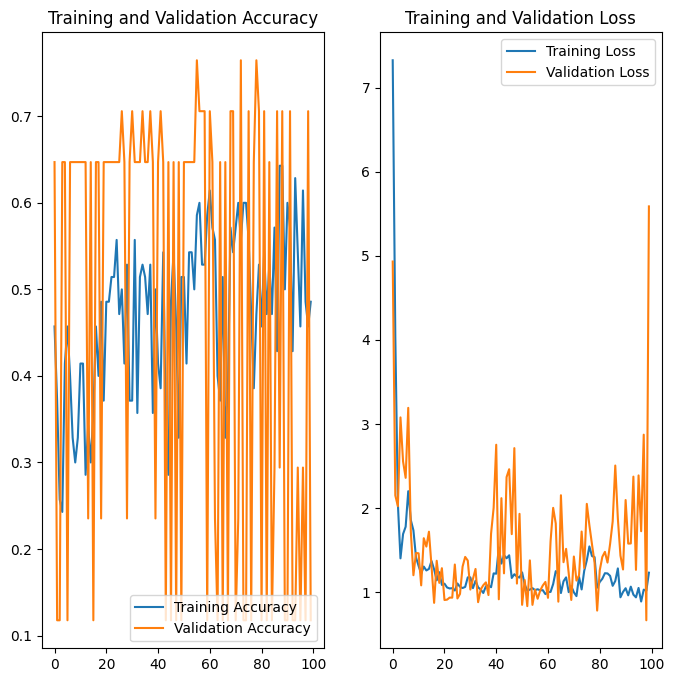

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Analysis
I found it interesting how the validation accuracy and training accuracy were continuously spiking. This may have been because of the relatively small dataset, causing the accuracy to vary drastically over a small error. The accuracy rose relatively quickly, doing fairly well, starting at barely more than 0.3, and at its peak near 1.The loss did relatively well lowering drastically from its high at above 1.4 to its low at about 0.1. This graph also displayed continuous spiking; notably with the validation loss, however I am inclined to believe it is for the same reason as I explained before. One major difference, however, is that there is one extremely high spike, and this is never displayed in the accuracy graph. In the loss graph, the spikes for the validation set loss seem to be rising ever higher and higher, while the training set loss is not rising and keeping relatively stable. This may be a sign of overfitting, meaning that the model is too fixated on the training data and does not generalize well to the validation set and sets other than the training data.

## Full report
You can find my full report [here](https://docs.google.com/document/d/1RwKeY6YBt78o5mXYlY1CTxEmzPjnW8TjKWBZwhSzqrs/edit?usp=sharing).